In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import integrate, interpolate, special
from scipy.special import psi
from scipy.stats import gengamma, laplace, norm, kstwo, ks_1samp
import matplotlib.pyplot as plt
import pickle
import os
import math
from scipy.linalg import svd
import matplotlib.pyplot as plt
from scipy.misc import derivative
import matplotlib.patches as patches

In [2]:
psi(0)

-inf

In [3]:

def derivative_r(r, eta, scale=1):
    beta = (eta + 1.5) / r

    def gauss_density(theta, x):
        return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)

    def gen_gamma_density(theta):
        return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)

    def integrand_up(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta) * math.log(theta) * theta ** r

    def integrand_down(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta)

    def integral_up(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_up(theta, x), 0, np.inf)
        return result

    def integral_down(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result

    def integral_ratio(x):
        up = integral_up(x)
        down = integral_down(x)
        return up / down if down != 0 else float('inf')  # Avoid division by zero

    psi_value = scipy.special.psi((eta + 0.5) / r) * ((eta + 0.5) / r**2)

    return lambda x: r**-1 + psi_value - integral_ratio(x)


In [4]:
def derivative_eta(r, eta, scale=1):
    beta = (eta + 1.5) / r

    def gauss_density(theta, x):
        return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)

    def gen_gamma_density(theta):
        return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)

    def integrand_up(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta) * math.log(theta)

    def integrand_down(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta)

    def integral_up(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_up(theta, x), 0, np.inf)
        return result

    def integral_down(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result

    def integral_ratio(x):
        up = integral_up(x)
        down = integral_down(x)
        return up / down if down != 0 else float('inf')  # Avoid division by zero

    psi_value = - scipy.special.psi((eta + 0.5) / r) * (1 / r)

    return lambda x: psi_value + integral_ratio(x)



In [5]:
def integrate_function_r_eta(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        dr_val = dr_func(x)
        de_val = de_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (dr_val * de_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result


In [6]:
def integrate_function_r_r(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        dr_val = dr_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (dr_val * dr_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result

In [7]:
def integrate_function_eta_eta(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        de_val = de_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (de_val * de_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result

In [17]:
def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def gen_gamma_variance(r, eta):
    mean = gen_gamma_mean(r, eta)
    second_moment = scipy.special.gamma((eta+3.5)/r) / scipy.special.gamma((eta+1.5)/r)
    return second_moment - mean**2

def find_eta_for_target_mean(r, target_mean):
    def objective(eta):
        return (gen_gamma_mean(r, eta) - target_mean)**2
    result = scipy.optimize.minimize_scalar(objective)
    return result.x

all_r_vals = []
all_eta_vals = []
target_vars = np.round(np.arange(2, 5, 1), 2)

for target_mean in target_vars:

    r_values = []
    eta_values = []
    mean_values = []
    variance_values = []

    for r in np.logspace(0, 1.2, 10):  # r from 1 to 1000 np.arange(0,10,1):
        eta = find_eta_for_target_mean(r, target_mean)
        mean = gen_gamma_mean(r, eta)
        variance = gen_gamma_variance(r, eta)
        if variance == np.nan or mean == np.nan:
            break
        
        r_values.append(r)
        eta_values.append(eta)
        mean_values.append(mean)
        variance_values.append(variance)

    all_r_vals.append(np.array(r_values))
    all_eta_vals.append(np.array(eta_values))

all_r_vals, all_eta_vals

C:\Users\yashd\AppData\Local\Temp\ipykernel_29520\3582664690.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


([array([ 1.        ,  1.35935639,  1.8478498 ,  2.51188643,  3.41454887,
          4.64158883,  6.30957344,  8.57695899, 11.65914401, 15.84893192]),
  array([ 1.        ,  1.35935639,  1.8478498 ,  2.51188643,  3.41454887,
          4.64158883,  6.30957344,  8.57695899, 11.65914401, 15.84893192]),
  array([ 1.        ,  1.35935639,  1.8478498 ,  2.51188643,  3.41454887,
          4.64158883,  6.30957344,  8.57695899, 11.65914401, 15.84893192])],
 [array([5.00000000e-01, 2.15741096e+00, 5.56050289e+00, 1.35674838e+01,
         3.61046093e+01, 1.16170902e+02, 5.01613278e+02,            nan,
                    nan,            nan]),
  array([  1.5       ,   4.72604205,  12.98746788,  38.92148393,
         145.0783664 , 761.11415274,          nan,          nan,
                  nan,          nan]),
  array([  2.5       ,   7.62418192,  22.86297558,  80.96909039,
         387.94284349,          nan,          nan,          nan,
                  nan,          nan])])

In [51]:
R, Eta = all_r_vals, all_eta_vals

In [52]:
def hessian(r, eta):
        # Hessian matrix
    H = np.array([[integrate_function_r_r(r, eta), integrate_function_r_eta(r, eta)],
                  [integrate_function_r_eta(r, eta), integrate_function_eta_eta(r, eta)]])
    return H

In [53]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [54]:
import math
math.isnan(all_eta_vals[-1][-1])

True

1.0 0.5
[[ 4.75283444 -2.13959997]
 [-2.13959997  1.24221068]]
1.0 2.16
[[10.54433594 -1.47205889]
 [-1.47205889  0.22283401]]
1.0 5.56
[[19.95574282 -1.01363521]
 [-1.01363521  0.05289705]]
1.0 13.57
[[ 3.51168827e+01 -6.38090854e-01]
 [-6.38090854e-01  1.16855145e-02]]
1.0 36.1
[[ 6.85492025e+03 -1.37995962e+02]
 [-1.37995962e+02  1.95210888e-03]]
1.36 1.5
[[ 1.94502644 -0.6240875 ]
 [-0.6240875   0.23374529]]
1.36 4.73
[[ 4.41320445 -0.41523161]
 [-0.41523161  0.04073461]]
1.36 12.99
[[ 8.72421774e+00 -2.49370539e-01]
 [-2.49370539e-01  7.19891286e-03]]
1.36 38.92
[[ 1.59742061e+01 -1.23066535e-01]
 [-1.23066535e-01  9.49679103e-04]]
1.85 2.5
[[ 0.63765188 -0.19995281]
 [-0.19995281  0.07063655]]
1.85 7.62
[[ 1.50430934 -0.12546276]
 [-0.12546276  0.01074553]]
1.85 22.86
[[ 3.07346045e+00 -6.65098579e-02]
 [-6.65098579e-02  1.44582606e-03]]
1.85 80.97
[[ 5.76478157e+00 -2.70844150e-02]
 [-2.70844150e-02  1.27319692e-04]]


IndexError: list index out of range

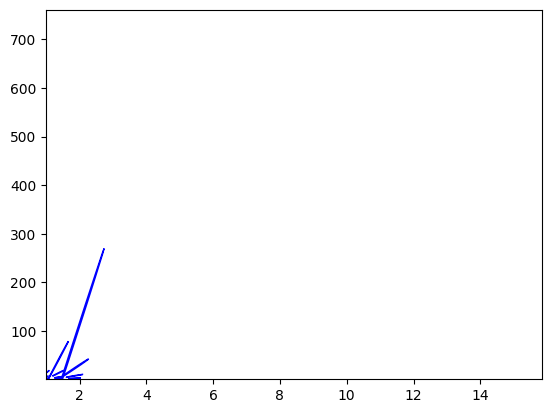

In [55]:
# Initialize the plot EDITED
fig, ax = plt.subplots()
ax.set_xlim(np.min(R), np.max(R))
ax.set_ylim(np.nanmin(Eta), np.nanmax(Eta))


scale_factor = 0.1
pos_list = []
# Compute and plot the ellipses
# Define directories for storing Hessian matrices
hessian_dir = 'hessian_matrices'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (R, Eta) pair
def get_hessian_path(r, eta):
    return os.path.join(hessian_dir, f'hessian_R{r}_Eta{eta}.pkl')

# Loop through R and Eta values
for i, R in enumerate(all_r_vals[0]):
    for j, Eta in enumerate(all_eta_vals[min(i, len(all_eta_vals))]):
        if math.isnan(Eta) or math.isnan(R):
            continue 
        R, Eta = np.round(R, 2), np.round(Eta, 2)
        
        hessian_path = get_hessian_path(R, Eta)
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            # Calculate the Hessian matrix if not already stored
            H = hessian(R, Eta)
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        if math.isnan(H[0][0]):
            continue
        
        pos_list.append(is_pos_def(H))
        print(R, Eta)
        print(H)
        
        U, s, Vt = np.linalg.svd(H)
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R, Eta), width, height, angle=angle, edgecolor='blue', facecolor='none')
        ax.add_patch(ellipse)

print(pos_list)

plt.title('Ellipses Representing the SVD of the Hessian')
plt.xlabel('r')
plt.ylabel('eta')
plt.show()

for i, (r_values, eta_values) in enumerate(zip(all_r_vals, all_eta_vals)):
    all_beta_vals = np.divide((eta_values + 1.5), r_values)
    sns.lineplot(x = r_values, 
                 y = eta_values,
                 label = f'{target_vars[i]}'
                 )
plt.title(f'$\\eta$ as a function of $r$ for different target variances')
plt.xlabel('r')
plt.ylabel(f'$\\eta$')

In [ ]:
is_pos_def(np.array([[40.60756154,-31160.34090121],
[-31160.34090121, 4902.34950896]]))

False